In [2]:
import os
import cv2
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new"
bgr_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\data_gen\sd_v20_background_images_new"

obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))
bgr_imgs = glob.glob(os.path.join(bgr_dir, "*.jpg")) + glob.glob(os.path.join(bgr_dir, "*.png"))
len(obj_imgs), len(bgr_imgs)

(2, 3)

In [10]:
obj_img_path = obj_imgs[0]
bgr_img_path = bgr_imgs[0]

In [11]:
obj_img = cv2.imread(obj_img_path)
bgr_img = cv2.imread(bgr_img_path)

##### Plot the images

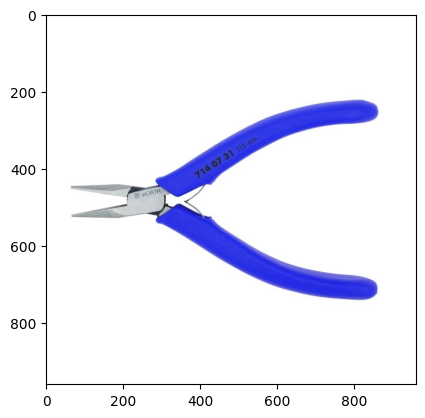

In [12]:
plt.imshow(obj_img)

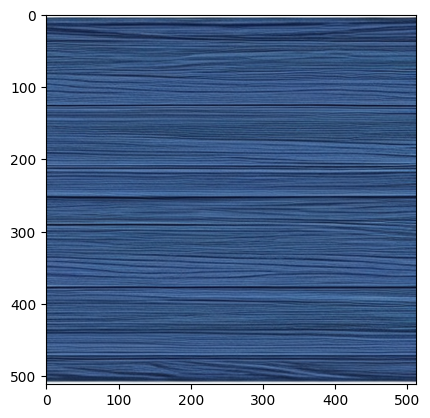

In [13]:
plt.imshow(bgr_img)

### shapes of both images

In [14]:
obj_img.shape, bgr_img.shape

((960, 960, 3), (512, 512, 3))

In [15]:
temp = Image.open(obj_img_path)
temp.size, temp.mode, len(temp.mode)

((960, 960), 'RGB', 3)

### Extracting the mask

##### Using MobileSAM

In [18]:
from ultralytics import SAM
weights = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\weights\mobile_sam.pt"
model = SAM(weights)

h, w = obj_img.shape[:2]
bbox = [0, 0, w, h]
masks = model.predict(obj_img_path, bboxes = bbox)
len(masks), len(masks[0])


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new\1271810_new_0.jpg: 1024x1024 6219.2ms
Speed: 43.1ms preprocess, 6219.2ms inference, 17.0ms postprocess per image at shape (1, 3, 1024, 1024)


(1, 1)

In [19]:
masks[0].masks.data.shape

torch.Size([1, 960, 960])

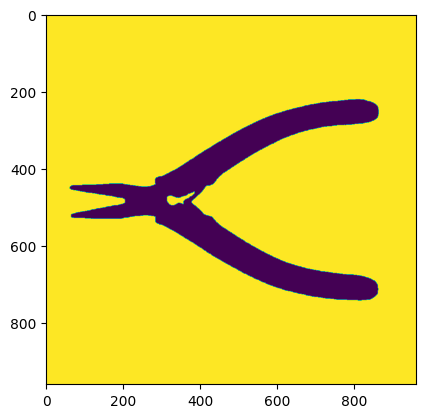

In [20]:
plt.imshow(masks[0].masks.data[0])

In [21]:
mask = masks[0].masks.data[0]
mask.dtype

torch.bool

In [22]:
def find_object_angle(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Get the bounding rotated rectangle
    rotated_rect = cv2.minAreaRect(contours[0])
    
    # Extract the angle from the rotated rectangle
    angle = rotated_rect[-1]
    
    return angle

In [23]:
angle = find_object_angle(~mask.detach().numpy())
angle

0.1253734976053238


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new\1271810_new_0.jpg: 1024x1024 6151.7ms
Speed: 29.6ms preprocess, 6151.7ms inference, 26.9ms postprocess per image at shape (1, 3, 1024, 1024)


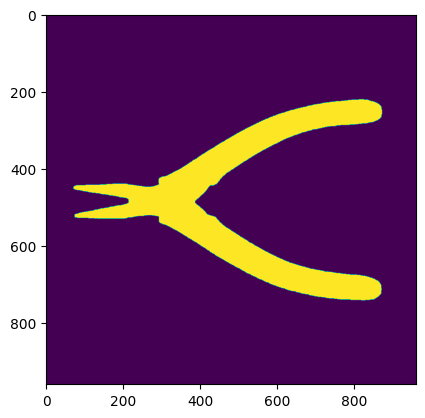

In [24]:
def get_mask(obj_img_path):
    img = cv2.imread(obj_img_path)
    h, w = img.shape[:2]
    bbox = [0, 0, w, h]
    masks = model.predict(obj_img_path, bboxes = bbox)
    return masks[0].masks.data[0]

def rotate_image(image):
    # Generate a random angle between 0 and 360 degrees
    random_angle = np.random.uniform(0, 360)

    # Get the center of the image
    rows, cols = image.shape[:2]
    center = (cols // 2, rows // 2)

    # Generate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, random_angle, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_image

def find_object_angle(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Get the bounding rotated rectangle
    rotated_rect = cv2.minAreaRect(contours[0])
    
    # Extract the angle from the rotated rectangle
    angle = rotated_rect[-1]
    
    return angle

def create_alpha_channel(image_path, mask):
    image = image_path
    # Read the image with a transparent background (PNG or GIF)
    #image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # If the image already has an alpha channel, return it
    if image.shape[2] == 4:
        return image

    # Create an alpha channel based on a mask
    alpha_channel = np.where(mask, 0, 255).astype(np.uint8)

    # Apply morphological operations to remove noise from the borders
    kernel = np.ones((3, 3), np.uint8)
    alpha_channel = cv2.erode(alpha_channel, kernel, iterations=1)
    alpha_channel = cv2.dilate(alpha_channel, kernel, iterations=1)
    
    # Apply opening operation to remove small white regions (noise)
    alpha_channel = cv2.morphologyEx(alpha_channel, cv2.MORPH_OPEN, kernel)

    # Add the alpha channel to the original image
    image_with_alpha = np.dstack([image, alpha_channel])

    # Crop the image based on the alpha channel
    alpha_channel_binary = (alpha_channel != 0).astype(np.uint8)
    contours, _ = cv2.findContours(alpha_channel_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the bounding box of the contours
    bounding_box = cv2.boundingRect(contours[0])

    # Extract the region of interest (ROI) based on the bounding box
    cropped_image_with_alpha = image_with_alpha[bounding_box[1]:bounding_box[1]+bounding_box[3],
                                                 bounding_box[0]:bounding_box[0]+bounding_box[2]]
    return image_with_alpha


def remove_border_noise(mask, n):
    # Convert the mask to binary
    mask_binary = np.where(mask > 0, 1, 0).astype(np.uint8)

    # Create a structuring element for erosion
    kernel = np.ones((n, n), np.uint8)

    # Perform morphological erosion
    mask_eroded = cv2.erode(mask_binary, kernel, iterations=1)

    # Convert the eroded mask back to the original data type
    mask_eroded = np.where(mask_eroded > 0, 255, 0).astype(np.uint8)

    return mask_eroded

def create_shadow(mask, angle, shift_distance=0):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Get the contour of the object
    contour = contours[0]
    
    # Create an empty mask for the shadow
    shadow_mask = np.zeros_like(mask, dtype=np.uint8)
    
    # Calculate the shift vector based on the angle
    shift_x = int(shift_distance * np.cos(np.radians(angle)))
    shift_y = int(shift_distance * np.sin(np.radians(angle)))
    
    # Shift each point of the contour
    shifted_contour = contour.copy()  # Make a copy to avoid modifying the original contour
    for point in shifted_contour:
        point[0][0] += shift_x
        point[0][1] += shift_y
    
    # Draw the shifted contour on the shadow mask
    cv2.drawContours(shadow_mask, [shifted_contour], -1, (255), thickness=cv2.FILLED)
    
    return shadow_mask

def subtract_masks(original_mask, shadow_mask):
    # Perform bitwise XOR operation between the original and shadow masks
    remaining_mask = cv2.bitwise_xor(original_mask, shadow_mask)
    return remaining_mask

def show_difference(shadow_mask, mask):
    # Convert masks to boolean
    shadow_bool = shadow_mask.astype(bool)
    mask_bool = mask.astype(bool)

    # Find the area in shadow_mask that does not exist in mask
    difference = shadow_bool ^ mask_bool

    # Convert the resulting boolean mask back to uint8 for visualization
    difference_uint8 = difference.astype(np.uint8) * 255

    return difference_uint8


def show_difference(shadow_mask, mask):
    # Convert masks to boolean arrays
    shadow_mask_bool = shadow_mask.astype(bool)
    mask_bool = mask.astype(bool)

    # Find the area that exists in shadow_mask but not in mask
    difference_bool = np.logical_and(shadow_mask_bool, np.logical_not(mask_bool))

    # Convert the boolean array back to uint8
    difference_uint8 = difference_bool.astype(np.uint8) * 255

    return difference_uint8

def blur_difference_image(difference_image, blur_radius=5):
    # Apply Gaussian blur to the difference image
    blurred_image = cv2.GaussianBlur(difference_image, (blur_radius, blur_radius), 0)
    
    return blurred_image

def add_shadow_to_image(original_image, difference_image):
    # Create a mask where the difference exists
    shadow_mask = (difference_image > 0).astype(np.uint8)

    # Convert shadow mask to 3 channels
    shadow_mask_3channels = np.repeat(shadow_mask[:, :, np.newaxis], 3, axis=2)

    # Create a copy of the original image
    image_with_shadow = original_image.copy()

    # Overlay the shadow region onto the original image
    image_with_shadow[shadow_mask_3channels == 1] = 127  # Set shadowed region to black
    image_with_shadow[shadow_mask_3channels == 1] = 30  # Set shadowed region to black

    return image_with_shadow

def create_alpha_channel_with_shadow(image, mask, distance = 10):
    mask_eroded = remove_border_noise(~mask.detach().numpy(), 3)
    angle = find_object_angle(~mask_eroded)
    shadow_mask = create_shadow(mask_eroded, angle, distance)
    mask_difference = show_difference(shadow_mask, mask_eroded)
    blurred_difference_mask = blur_difference_image(mask_difference, blur_radius=5)
    plt.imshow(mask_difference)
    image_with_shadow = add_shadow_to_image(obj_img, blurred_difference_mask)
    plt.imshow(image_with_shadow)
    full_mask = blurred_difference_mask.astype(bool) | mask_eroded.astype(bool)
    cropped_image_squarely = create_alpha_channel(image_with_shadow, ~full_mask)
    return cropped_image_squarely

def paste_image(background, foreground, position=(0, 0)):
    """
    Paste a smaller image (foreground) onto a larger image (background) at the specified position.
    
    Parameters:
        - background (numpy.ndarray): The larger image.
        - foreground (numpy.ndarray): The smaller image to be pasted.
        - position (tuple): The position (x, y) where the top-left corner of the smaller image will be placed.
        
    Returns:
        - numpy.ndarray: The resulting image with the smaller image pasted onto the larger one.
    """
    h, w = foreground.shape[:2]
    background = cv2.resize(background, (h + 400, w + 400))
    
    center_x = np.random.randint(0, 1024)
    center_y = np.random.randint(0, 1024)
    
    # Ensure the position is within the bounds of the background image
    y, x = (center_y, center_x)
    y = max(0, min(y, background.shape[0] - h))
    x = max(0, min(x, background.shape[1] - w))
    
    # Create a region of interest (ROI) for the smaller image on the background
    roi = background[y:y + h, x:x + w]
    
    # Create a mask for the foreground image
    mask = (foreground[:, :, 3] / 255.0).reshape((h, w, 1))
    
    # Blend the images using the alpha channel of the foreground
    blended = roi * (1 - mask) + foreground[:, :, :3] * mask
    
    # Update the background with the blended region
    background[y:y + h, x:x + w] = blended
    
    return background

mask = get_mask(obj_img_path)
angle = find_object_angle(~mask.detach().numpy())
mask = masks[0].masks.data[0]
shadow_mask = create_shadow(~mask.detach().numpy(), angle, 10)
plt.imshow(shadow_mask)

In [25]:
np.sum(~mask.detach().numpy()), np.sum(shadow_mask.astype(bool))

(99826, 100897)

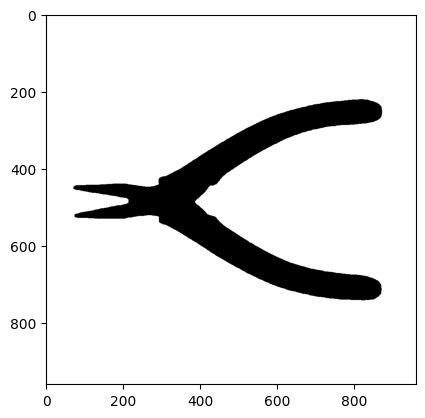

In [26]:
# Subtract the original mask from the shadow mask
remaining_mask = subtract_masks(shadow_mask, ~mask.detach().numpy().astype("uint8"))

# Display the remaining mask
plt.imshow(remaining_mask, cmap='gray')
plt.show()

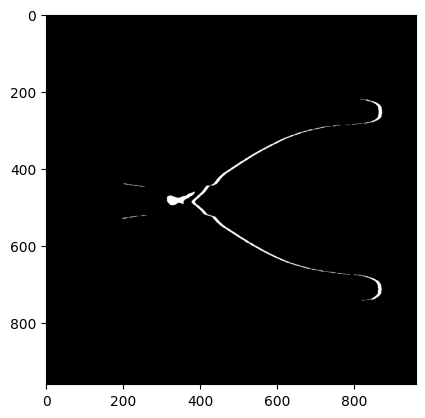

In [27]:
# Assuming you have shadow_mask and mask already defined
difference_image = show_difference(shadow_mask, ~mask.detach().numpy())

blurred_difference_image = blur_difference_image(difference_image, blur_radius=5)

# Display the resulting image
plt.imshow(difference_image, cmap='gray')
plt.show()

In [28]:
mask.detach().numpy().dtype, shadow_mask.astype(bool).dtype

(dtype('bool'), dtype('bool'))

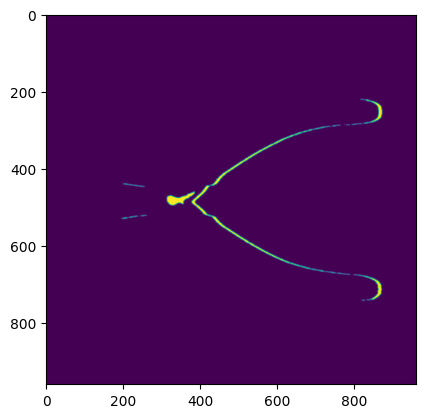

In [29]:
plt.imshow(blurred_difference_image)

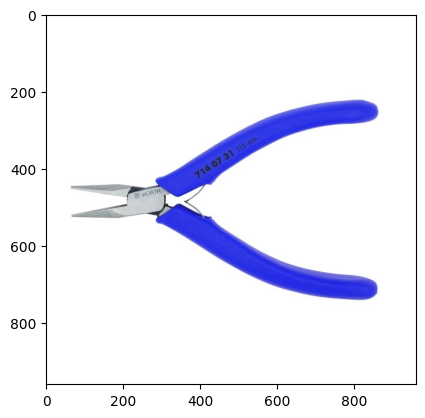

In [30]:
plt.imshow(obj_img)

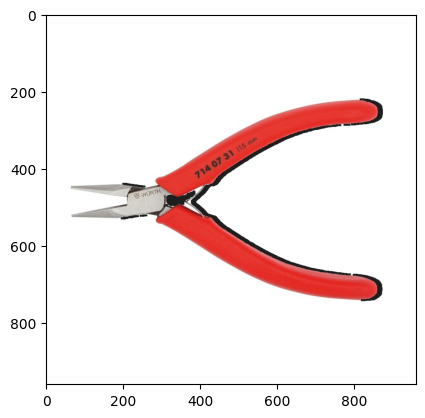

In [31]:
def add_shadow_to_image(original_image, difference_image):
    # Create a mask where the difference exists
    shadow_mask = (difference_image > 0).astype(np.uint8)

    # Convert shadow mask to 3 channels
    shadow_mask_3channels = np.repeat(shadow_mask[:, :, np.newaxis], 3, axis=2)

    # Create a copy of the original image
    image_with_shadow = original_image.copy()

    # Overlay the shadow region onto the original image
    image_with_shadow[shadow_mask_3channels == 1] = 127  # Set shadowed region to black
    image_with_shadow[shadow_mask_3channels == 1] = 30  # Set shadowed region to black

    return image_with_shadow

# Assuming you have the original_image and difference_image already defined
image_with_shadow = add_shadow_to_image(obj_img, difference_image)
image_with_shadow = add_shadow_to_image(obj_img, blurred_difference_image)

# Display the resulting image
plt.imshow(cv2.cvtColor(image_with_shadow, cv2.COLOR_BGR2RGB))
plt.show()

(dtype('uint8'), torch.bool, <matplotlib.image.AxesImage at 0x24135316530>)

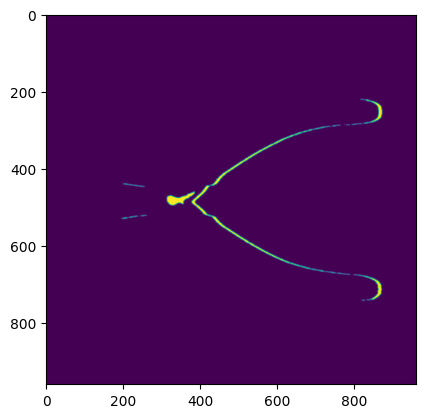

In [32]:
blurred_difference_image.dtype, mask.dtype, plt.imshow(blurred_difference_image)

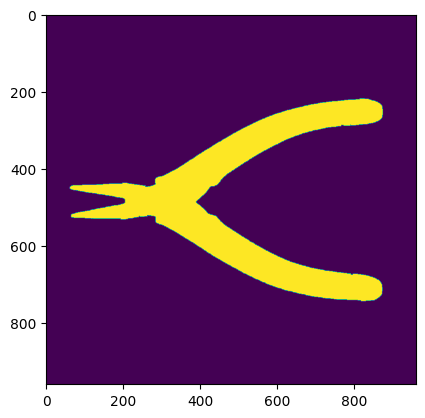

In [33]:
full_mask = blurred_difference_image.astype(bool) | ~mask.detach().numpy()
plt.imshow(full_mask)

(dtype('uint8'), dtype('bool'), <matplotlib.image.AxesImage at 0x241373f1a50>)

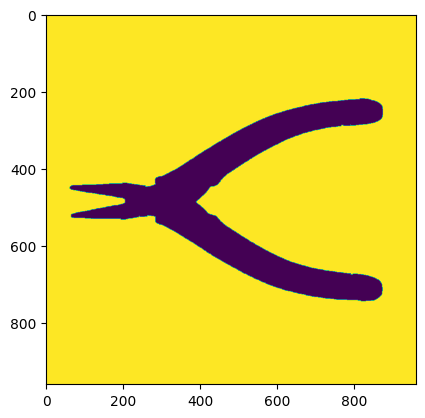

In [34]:
image_with_shadow.dtype, full_mask.dtype, plt.imshow(~full_mask)

(dtype('uint8'), torch.bool, <matplotlib.image.AxesImage at 0x24135f70e50>)

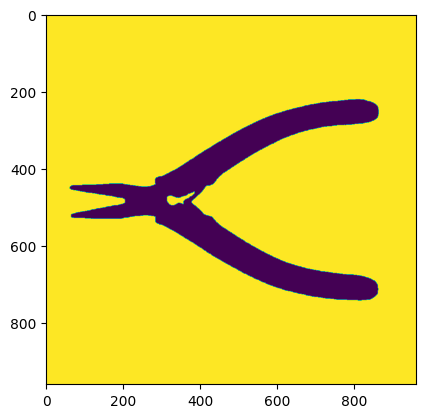

In [35]:
obj_img.dtype, mask.dtype, plt.imshow(mask)

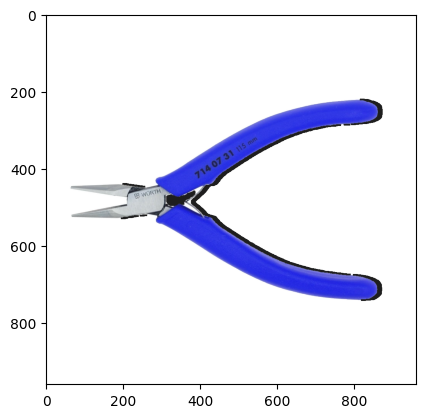

In [36]:
cropped_image_squarely = create_alpha_channel(image_with_shadow, ~full_mask)
plt.imshow(cropped_image_squarely)

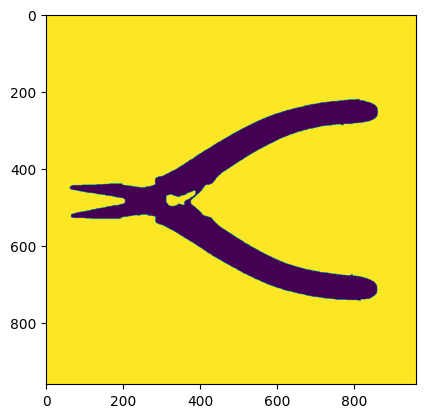

In [37]:
plt.imshow(np.logical_or(mask.detach().numpy().astype(bool), blurred_difference_image.astype(bool)))

In [38]:
np.sum(np.logical_or(mask.detach().numpy().astype(bool), blurred_difference_image.astype(bool))), np.sum(mask.detach().numpy()), np.sum(blurred_difference_image.astype(bool))

(825690, 821774, 13317)

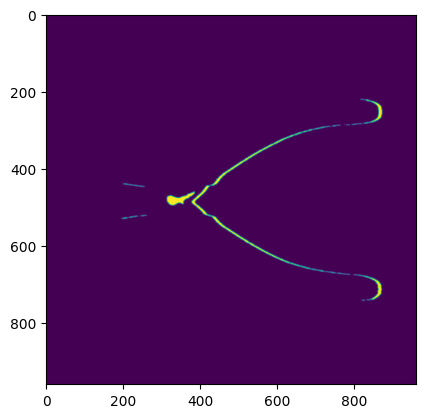

In [39]:
plt.imshow(blurred_difference_image)

(109227, <matplotlib.image.AxesImage at 0x24137797a90>)

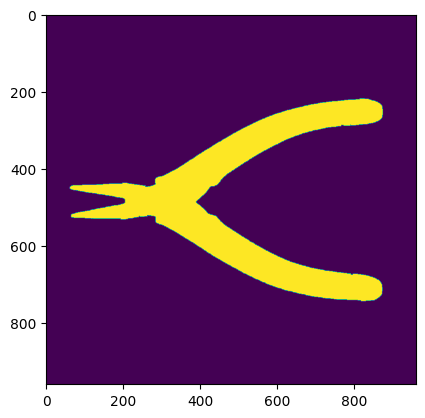

In [40]:
new_mask = ~mask.detach().numpy().astype(bool) + blurred_difference_image.astype(bool)
np.sum(new_mask), plt.imshow(new_mask)

In [41]:
np.sum(np.logical_and(mask.detach().numpy().astype(bool), blurred_difference_image.astype(bool)))

9401

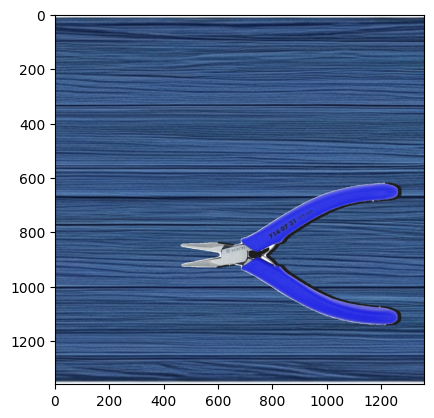

In [43]:
result_image = paste_image(cv2.imread(bgr_imgs[0]), cropped_image_squarely)
plt.imshow(result_image)

In [44]:
def create_alpha_channel_with_shadow(image, mask, distance = 10):
    mask_eroded = remove_border_noise(~mask.detach().numpy(), 3)
    angle = find_object_angle(~mask_eroded)
    shadow_mask = create_shadow(mask_eroded, angle, distance)
    mask_difference = show_difference(shadow_mask, mask_eroded)
    blurred_difference_mask = blur_difference_image(mask_difference, blur_radius=5)
    #plt.imshow(blurred_difference_mask)
    plt.imshow(mask_eroded)
    #plt.imshow(mask_difference)
    image_with_shadow = add_shadow_to_image(obj_img, blurred_difference_mask)
    #plt.imshow(image_with_shadow)
    full_mask = blurred_difference_mask.astype(bool) | mask_eroded.astype(bool)
    plt.imshow(full_mask)
    cropped_image_squarely = create_alpha_channel(image_with_shadow, ~full_mask)
    return cropped_image_squarely

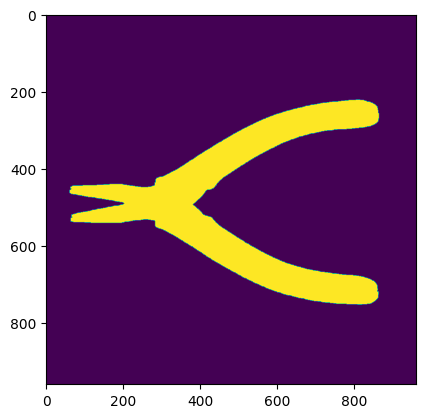

In [45]:
alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
#plt.imshow(alpha_channel_with_shadow)
#plt.imshow(alpha_channel_with_shadow[:, :, 3])

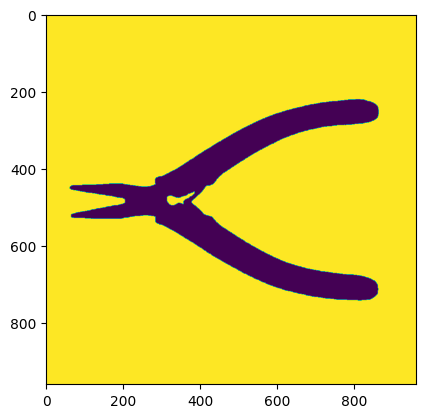

In [46]:
plt.imshow(mask)

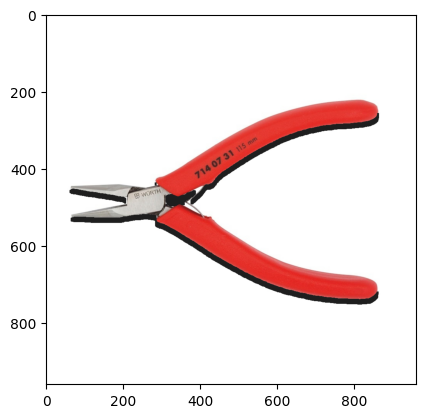

In [47]:
#alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
plt.imshow(cv2.cvtColor(alpha_channel_with_shadow, cv2.COLOR_BGRA2RGB))

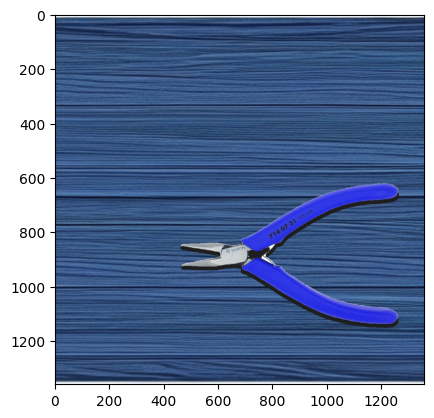

In [48]:
result_image = paste_image(cv2.imread(bgr_imgs[0]), alpha_channel_with_shadow)
plt.imshow(result_image)

In [49]:
alpha_channel_with_shadow.shape

(960, 960, 4)

### Shadow super-impose


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535_new\150535_new_0.jpg: 1024x1024 5978.4ms
Speed: 32.0ms preprocess, 5978.4ms inference, 16.9ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_new\150535_new\150535_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_new\150535_new\150535_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_new\150535_new\150535_new_0_table03.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535_new\150535_new_216.jpg: 1024x1024 5879.2ms
Speed: 26.6ms preprocess, 5879.2ms inference, 17.2ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_te

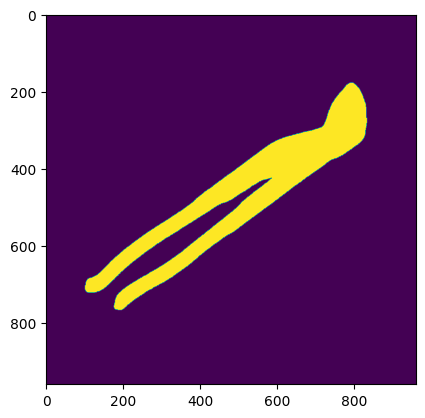

In [58]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new"
bgr_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\data_gen\sd_v20_background_images_new"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_new"

from ultralytics import SAM
weights = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\weights\mobile_sam.pt"
model = SAM(weights)

def shadow_super_impose(objects_dir, bgr_dir, results_dir):
    obj_imgs = glob.glob(os.path.join(objects_dir, "*.jpg"))
    bgr_imgs = glob.glob(os.path.join(bgr_dir, "*.png"))
    
    dir_name = obj_imgs[0].split("\\")[-2]
    os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

    for obj_image_path in obj_imgs:
        obj_img_name = obj_image_path.split("\\")[-1].split(".")[0]
        obj_image = cv2.imread(obj_image_path)

        obj_img = cv2.imread(obj_image_path)
        mask = get_mask(obj_image_path)

        for bgr_img_path in bgr_imgs:
            bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
            alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
            rotated_image = rotate_image(alpha_channel_with_shadow)
            result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)

            save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
            print(save_name)
            cv2.imwrite(save_name, result_image)
            



shadow_super_impose(obj_dir, bgr_dir, results_dir)

In [57]:
glob.glob(os.path.join(bgr_dir, "*.png"))

['C:\\Users\\kaleem\\Learn\\Wuerth\\thesis\\data\\data_temp\\datasets_temp\\test_set\\data_gen\\sd_v20_background_images_new\\table01.png',
 'C:\\Users\\kaleem\\Learn\\Wuerth\\thesis\\data\\data_temp\\datasets_temp\\test_set\\data_gen\\sd_v20_background_images_new\\table02.png',
 'C:\\Users\\kaleem\\Learn\\Wuerth\\thesis\\data\\data_temp\\datasets_temp\\test_set\\data_gen\\sd_v20_background_images_new\\table03.png']


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874\141874_new_0.jpg: 1024x1024 6180.7ms
Speed: 34.5ms preprocess, 6180.7ms inference, 15.6ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_0_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_0_table04.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_0_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_108_table30.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table14.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table15.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table16.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_180_table17.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_216_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_216_table35.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874\141874_new_252.jpg: 1024x1024 6149.0ms
Speed: 32.5ms preprocess, 6149.0ms inference, 16.1ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_252_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_252_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_252_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\da

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table21.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table22.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_288_table27.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table08.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table14.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_36_table15.png
C:\Users\kaleem\Learn\Wuert

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_72_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_72_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\141874\141874_new_72_table35.png


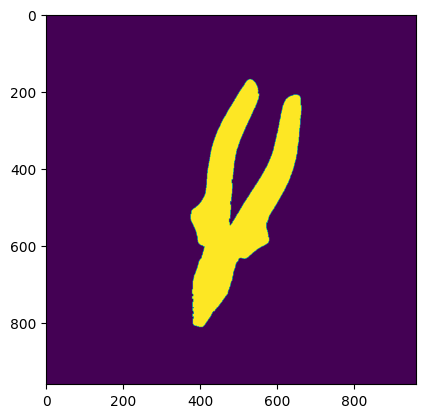

In [88]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874"
obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))

results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\orig_super_impose_shadow"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow"

dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_image_path in obj_imgs:
    obj_img_name = obj_image_path.split("\\")[-1].split(".")[0]
    obj_image = cv2.imread(obj_image_path)
    
    obj_img = cv2.imread(obj_image_path)
    mask = get_mask(obj_image_path)

    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
        rotated_image = rotate_image(alpha_channel_with_shadow)
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)

In [89]:
results_dir, os.path.join(results_dir, dir_name)

('C:\\Users\\kaleem\\Learn\\Wuerth\\thesis\\data\\data_temp\\datasets_temp\\test_set\\test\\sd_v20_super_impose_shadow',
 'C:\\Users\\kaleem\\Learn\\Wuerth\\thesis\\data\\data_temp\\datasets_temp\\test_set\\test\\sd_v20_super_impose_shadow\\141874')


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535\150535_new_0.jpg: 1024x1024 5913.3ms
Speed: 42.0ms preprocess, 5913.3ms inference, 15.6ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_0_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_0_table04.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_0_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_108_table30.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table14.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table15.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table16.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_180_table17.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_216_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_216_table35.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535\150535_new_252.jpg: 1024x1024 5872.2ms
Speed: 28.1ms preprocess, 5872.2ms inference, 15.7ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_252_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_252_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_252_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\da

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table21.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table22.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_288_table27.png
C:\Users\kaleem\Lear

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table08.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table14.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_36_table15.png
C:\Users\kaleem\Learn\Wuert

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_72_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_72_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\150535\150535_new_72_table35.png


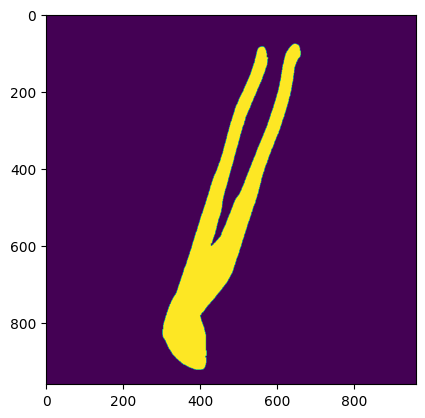

In [90]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535"
obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))

results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\orig_super_impose_shadow"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow"

dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_image_path in obj_imgs:
    obj_img_name = obj_image_path.split("\\")[-1].split(".")[0]
    obj_image = cv2.imread(obj_image_path)
    #mask = get_mask(obj_image_path)
    #print(obj_img_name)
    #mask = get_mask(obj_image_path)
    #plt.imshow(mask)
    
    obj_img = cv2.imread(obj_image_path)
    mask = get_mask(obj_image_path)

    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
        rotated_image = rotate_image(alpha_channel_with_shadow)
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)
        
        #print(bgr_img_name)
        #plt.imshow(result_image)
#mask = get_mask(obj_img_path)
#alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
#rotated_image = rotate_image(alpha_channel_with_shadow)
#result_image = paste_image(cv2.imread(bgr_imgs[0]), rotated_image)
#plt.imshow(result_image)


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810\1271810_new_0.jpg: 1024x1024 5882.1ms
Speed: 36.4ms preprocess, 5882.1ms inference, 15.5ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_0_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_0_table04.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_0_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\da

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_108_table29.png
C:\Use

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table14.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table15.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_180_table16.png
C:\Use

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_216_table32.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_216_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_216_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_216_table35.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810\1271810_new_252.jpg: 1024x1024 5909.9ms
Speed: 29.0ms preprocess, 5909.9ms inference, 15.6ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_252_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table19.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table20.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table21.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table22.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_288_table25.png
C:\Use

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table06.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table07.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table08.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_36_table12.png
C:\Users\kale

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table30.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table31.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table32.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow\1271810\1271810_new_72_table35.png


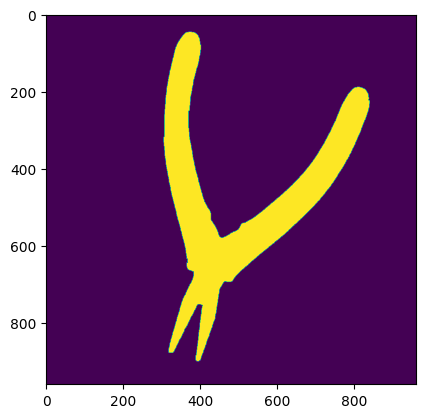

In [91]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810"
obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))

results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\orig_super_impose_shadow"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow"

dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_image_path in obj_imgs:
    obj_img_name = obj_image_path.split("\\")[-1].split(".")[0]
    obj_image = cv2.imread(obj_image_path)
    #mask = get_mask(obj_image_path)
    #print(obj_img_name)
    #mask = get_mask(obj_image_path)
    #plt.imshow(mask)
    
    obj_img = cv2.imread(obj_image_path)
    mask = get_mask(obj_image_path)

    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
        rotated_image = rotate_image(alpha_channel_with_shadow)
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)
        
        #print(bgr_img_name)
        #plt.imshow(result_image)
#mask = get_mask(obj_img_path)
#alpha_channel_with_shadow = create_alpha_channel_with_shadow(obj_img, mask)
#rotated_image = rotate_image(alpha_channel_with_shadow)
#result_image = paste_image(cv2.imread(bgr_imgs[0]), rotated_image)
#plt.imshow(result_image)

In [ ]:
def extract_object_mask(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold to create a binary image
    _, thresh = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(contours)

    # Create an empty mask
    mask = np.zeros_like(gray)

    # Draw contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    return mask

# Example usage
object_mask = extract_object_mask(obj_img)
plt.imshow(object_mask)

In [ ]:
plt.imshow(obj_img)

plt.imshow(cv2.imread(r"C:\Users\wn00217454\computer_vision\thesis\data\background_images\tg7.png"))

##### Create alpha channel

In [ ]:
def create_alpha_channel(image_path, mask):
    # Read the image with a transparent background (PNG or GIF)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # If the image already has an alpha channel, return it
    if image.shape[2] == 4:
        return image

    # Create an alpha channel based on a mask
    #mask = np.all(image[:, :, :3] == [255, 255, 255], axis=2)  # Assuming white is the background color
    #mask = masks[0].masks.data[0]
    plt.imshow(mask)
    alpha_channel = np.where(mask, 0, 255).astype(np.uint8)

    # Add the alpha channel to the original image
    image_with_alpha = np.dstack([image, alpha_channel])

    # Crop the image based on the alpha channel
    alpha_channel_binary = (alpha_channel != 0).astype(np.uint8)  # Ensure it's uint8
    contours, _ = cv2.findContours(alpha_channel_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the bounding box of the contours
    bounding_box = cv2.boundingRect(contours[0])

    # Extract the region of interest (ROI) based on the bounding box
    cropped_image_with_alpha = image_with_alpha[bounding_box[1]:bounding_box[1]+bounding_box[3],
                                                 bounding_box[0]:bounding_box[0]+bounding_box[2]]
    return image_with_alpha

def paste_image(background, foreground, position=(0, 0)):
    """
    Paste a smaller image (foreground) onto a larger image (background) at the specified position.
    
    Parameters:
        - background (numpy.ndarray): The larger image.
        - foreground (numpy.ndarray): The smaller image to be pasted.
        - position (tuple): The position (x, y) where the top-left corner of the smaller image will be placed.
        
    Returns:
        - numpy.ndarray: The resulting image with the smaller image pasted onto the larger one.
    """
    h, w = foreground.shape[:2]
    background = cv2.resize(background, (1024, 1024))
    
    center_x = np.random.randint(0, 1024)
    center_y = np.random.randint(0, 1024)
    
    y, x = (center_y, center_x)
    y = max(0, min(y, background.shape[0] - h))
    x = max(0, min(x, background.shape[1] - w))
    
    # Create a region of interest (ROI) for the smaller image on the background
    roi = background[y:y + h, x:x + w]
    
    # Create a mask for the foreground image
    mask = (foreground[:, :, 3] / 255.0).reshape((h, w, 1))
    
    # Blend the images using the alpha channel of the foreground
    blended = roi * (1 - mask) + foreground[:, :, :3] * mask
    
    # Update the background with the blended region
    background[y:y + h, x:x + w] = blended
    
    return background

In [ ]:
def create_alpha_channel(image_path, mask):
    image = image_path

    # If the image already has an alpha channel, return it
    if image.shape[2] == 4:
        return image

    # Create an alpha channel based on a mask
    alpha_channel = np.where(mask, 0, 255).astype(np.uint8)

    # Apply morphological operations to remove noise from the borders
    kernel = np.ones((3, 3), np.uint8)
    alpha_channel = cv2.erode(alpha_channel, kernel, iterations=1)
    alpha_channel = cv2.dilate(alpha_channel, kernel, iterations=1)
    
    # Apply opening operation to remove small white regions (noise)
    alpha_channel = cv2.morphologyEx(alpha_channel, cv2.MORPH_OPEN, kernel)

    # Add the alpha channel to the original image
    image_with_alpha = np.dstack([image, alpha_channel])

    # Crop the image based on the alpha channel
    alpha_channel_binary = (alpha_channel != 0).astype(np.uint8)
    contours, _ = cv2.findContours(alpha_channel_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the bounding box of the contours
    bounding_box = cv2.boundingRect(contours[0])

    # Extract the region of interest (ROI) based on the bounding box
    cropped_image_with_alpha = image_with_alpha[bounding_box[1]:bounding_box[1]+bounding_box[3],
                                                 bounding_box[0]:bounding_box[0]+bounding_box[2]]
    return image_with_alpha


def remove_border_noise(mask, n):
    # Convert the mask to binary
    mask_binary = np.where(mask > 0, 1, 0).astype(np.uint8)

    # Create a structuring element for erosion
    kernel = np.ones((n, n), np.uint8)

    # Perform morphological erosion
    mask_eroded = cv2.erode(mask_binary, kernel, iterations=1)

    # Convert the eroded mask back to the original data type
    mask_eroded = np.where(mask_eroded > 0, 255, 0).astype(np.uint8)

    return mask_eroded

In [ ]:
#(image_with_alpha, cropped_image_squarely) = create_alpha_channel(obj_img_path)
mask = masks[0].masks.data[0]
cropped_image_squarely = create_alpha_channel(obj_img_path, mask)
image_with_alpha = cropped_image_squarely.copy()

In [ ]:
plt.imshow(cropped_image_squarely), cropped_image_squarely.shape, image_with_alpha.shape

In [ ]:
plt.imshow(mask)

In [ ]:
mask_eroded = remove_border_noise(~mask, 3)
cropped_image_squarely = create_alpha_channel(obj_img_path, ~mask_eroded)
image_with_alpha = cropped_image_squarely.copy()
plt.imshow(mask_eroded), np.sum(mask.detach().numpy()), np.sum(mask_eroded)

In [ ]:
mask_eroded.dtype, plt.imshow(image_with_alpha)

In [ ]:
def paste_image(background, foreground, position=(0, 0), feather_radius=20):
    """
    Paste a smaller image (foreground) onto a larger image (background) at the specified position.
    
    Parameters:
        - background (numpy.ndarray): The larger image.
        - foreground (numpy.ndarray): The smaller image to be pasted.
        - position (tuple): The position (x, y) where the top-left corner of the smaller image will be placed.
        - feather_radius (int): The radius of the feathering effect.
        
    Returns:
        - numpy.ndarray: The resulting image with the smaller image pasted onto the larger one.
    """
    # Extract the dimensions of the foreground image
    h, w = foreground.shape[:2]
    
    # Resize the background image to a fixed size (e.g., 1024x1024)
    background = cv2.resize(background, (h + 400, w + 400))
    
    # Generate random center coordinates within the background image
    center_x = np.random.randint(0, 1024)
    center_y = np.random.randint(0, 1024)
    
    # Ensure the position is within the bounds of the background image
    y, x = (center_y, center_x)
    y = max(0, min(y, background.shape[0] - h))
    x = max(0, min(x, background.shape[1] - w))
    
    # Create a region of interest (ROI) for the smaller image on the background
    roi = background[y:y + h, x:x + w]
    
    # Create a mask for the foreground image
    mask = (foreground[:, :, 3] / 255.0).reshape((h, w, 1))
    
    # Apply feathering effect to the mask
    kernel = cv2.getGaussianKernel(feather_radius * 2 + 1, feather_radius)
    mask = cv2.filter2D(mask, -1, kernel * kernel.T, borderType=cv2.BORDER_CONSTANT)
    
    # Reshape mask to have three dimensions
    mask = np.expand_dims(mask, axis=-1)
    
    # Convert mask to 3 channels for proper blending
    mask_3channels = np.repeat(mask, 3, axis=2)
    
    # Blend the images using the alpha channel of the foreground with the feathered mask
    blended = roi * (1 - mask_3channels) + foreground[:, :, :3] * mask_3channels
    
    # Update the background with the blended region
    background[y:y + h, x:x + w] = blended
    
    return background

In [ ]:
#image_with_alpha = create_alpha_channel(obj_img_path)

# Display the image using plt.imshow()
plt.imshow(cv2.cvtColor(image_with_alpha, cv2.COLOR_BGRA2RGBA))
plt.title("Image with Alpha Channel")
plt.show()
image_with_alpha.shape

In [ ]:
#result_image = paste_image(bgr_img, image_with_alpha)
result_image = paste_image(cv2.imread(bgr_imgs[0]), image_with_alpha)
result_image

In [ ]:
plt.imshow(result_image)

In [ ]:
cv2.imread(bgr_imgs[1]).shape

In [ ]:
obj_img_path.split("\\")[-2], obj_img_path.split("\\")[-1]

##### Pipeline

In [ ]:
results_dir = r"C:\Users\wnxxxxxx\computer_vision\thesis\data\background_images_labelled"
results_dir = r"C:\Users\wnxxxxxx\computer_vision\thesis\data\datasets\generated_datasets\diffusion_models\labelled\new"

In [ ]:
def get_mask(imagepath):
    img = cv2.imread(imagepath)
    h, w = img.shape[:2]
    bbox = [0, 0, w, h]
    masks = model.predict(imagepath, bboxes = bbox)
    return masks[0].masks.data[0]

def rotate_image(image):
    # Generate a random angle between 0 and 360 degrees
    random_angle = np.random.uniform(0, 360)

    # Get the center of the image
    rows, cols = image.shape[:2]
    center = (cols // 2, rows // 2)

    # Generate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, random_angle, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_image

In [ ]:
# Original
dir_name = obj_img_path.split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_img_path in obj_imgs:
    obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        mask = get_mask(obj_img_path)
        image_with_alpha = create_alpha_channel(obj_img_path, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        cv2.imwrite(save_name, result_image)

In [ ]:
obj_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\expand_labelled_dataset_small"
obj_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\generated_datasets\diffusion_models\to_use\images"
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data"

In [ ]:
obj_imgs

In [ ]:
results_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\generated_datasets\diffusion_models\labelled\without_noise"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\orig_super_impose_shadow"
#results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow"
dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_image_path in obj_imgs:
    obj_img_name = obj_image_path.split("\\")[-1].split(".")[0]
    obj_image = cv2.imread(obj_image_path)
    mask = get_mask(obj_image_path)
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        mask_eroded = remove_border_noise(~mask, 3)
        #image_with_alpha = create_alpha_channel(obj_img_path, ~mask_eroded)
        image_with_alpha = create_alpha_channel_with_shadow(obj_image, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        #print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        cv2.imwrite(save_name, result_image)
        break
    break

In [ ]:
plt.imshow(result_image)

In [ ]:
plt.imshow(mask)

In [ ]:
plt.imshow(image_with_alpha)

In [ ]:
len(obj_imgs), len(bgr_imgs)

In [ ]:
dir_name = obj_img_path.split("\\")[-2]
dir_name

In [ ]:
results_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\generated_datasets\diffusion_models\labelled\without_noise_with_shadow"
results_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\datasets\test_set\super_impose_real"
results_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose"
dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_img_path in obj_imgs:
    obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
    obj_img = cv2.imread(obj_img_path)
    mask = get_mask(obj_img_path)
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        image_with_alpha = create_alpha_channel_with_shadow(obj_img, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        #print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535\150535_new_0.jpg: 1024x1024 9887.2ms
Speed: 67.2ms preprocess, 9887.2ms inference, 31.6ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_0_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_0_table04.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_0_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\1

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table30.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table31.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table32.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_108_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table17.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table18.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table19.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table20.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table21.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table22.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_180_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table06.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table07.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table08.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_252_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_288_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_288_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_288_table35.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535\150535_new_324.jpg: 1024x1024 10173.7ms
Speed: 57.3ms preprocess, 10173.7ms inference, 31.4ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_324_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_324_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\150535\150535_new_36_table30.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\te

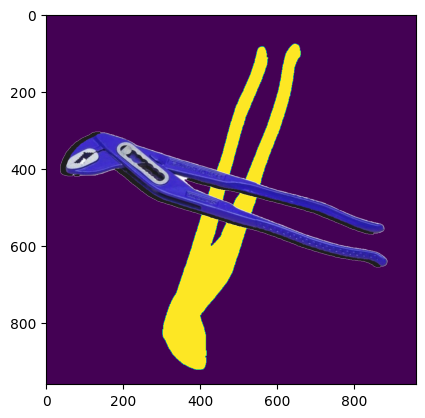

In [86]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\150535"
obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))

dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_img_path in obj_imgs:
    obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
    obj_img = cv2.imread(obj_img_path)
    mask = get_mask(obj_img_path)
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        image_with_alpha = create_alpha_channel_with_shadow(obj_img, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        #print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874\141874_new_0.jpg: 1024x1024 9549.3ms
Speed: 51.9ms preprocess, 9549.3ms inference, 25.1ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_0_table03.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_0_table04.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_0_table05.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\1

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table30.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table31.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table32.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_108_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table17.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table18.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table19.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table20.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table21.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table22.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_180_table23.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table06.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table07.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table08.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table10.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table11.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table12.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_252_table13.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_288_table33.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_288_table34.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_288_table35.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874\141874_new_324.jpg: 1024x1024 9837.5ms
Speed: 59.5ms preprocess, 9837.5ms inference, 31.3ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_324_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_324_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_su

C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table24.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table25.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table26.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table27.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table28.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table29.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose\141874\141874_new_36_table30.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\te

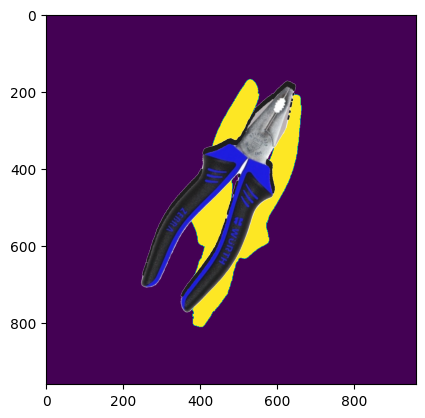

In [87]:
obj_dir = r"C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\141874"
obj_imgs = glob.glob(os.path.join(obj_dir, "*.jpg"))

dir_name = obj_imgs[0].split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_img_path in obj_imgs:
    obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
    obj_img = cv2.imread(obj_img_path)
    mask = get_mask(obj_img_path)
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        image_with_alpha = create_alpha_channel_with_shadow(obj_img, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        #print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        print(save_name)
        cv2.imwrite(save_name, result_image)

In [90]:
print(f"Total number of folders = {len(os.listdir(obj_dir))}")
for obj_folder in os.listdir(obj_dir):
    os.makedirs(os.path.join(results_dir, obj_folder), exist_ok=True)
    path = os.path.join(obj_dir, obj_folder)
    print(os.path.exists(path))
    obj_imgs = glob.glob(os.path.join(path, "*.jpg"))

    print(f"Number of Images in this directory {obj_folder} = {len(obj_imgs)}")
    
    for obj_img_path in obj_imgs:
        obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
        print(f"Image: {obj_img_name}")
    
        for bgr_img_path in bgr_imgs:
            bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
            mask = get_mask(obj_img_path)
            image_with_alpha = create_alpha_channel(obj_img_path, mask)
            
            rotated_image = rotate_image(image_with_alpha)
            plt.imshow(rotated_image)
            print(rotated_image.shape)
            
            result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
            
            save_name = os.path.join(os.path.join(results_dir, obj_folder), obj_img_name + "_" + bgr_img_name  + ".png")
            cv2.imwrite(save_name, result_image)

Total number of folders = 10
True
Number of Images in this directory 141874_new_0.jpg = 0
True
Number of Images in this directory 141874_new_108.jpg = 0
True
Number of Images in this directory 141874_new_144.jpg = 0
True
Number of Images in this directory 141874_new_180.jpg = 0
True
Number of Images in this directory 141874_new_216.jpg = 0
True
Number of Images in this directory 141874_new_252.jpg = 0
True
Number of Images in this directory 141874_new_288.jpg = 0
True
Number of Images in this directory 141874_new_324.jpg = 0
True
Number of Images in this directory 141874_new_36.jpg = 0
True
Number of Images in this directory 141874_new_72.jpg = 0


In [91]:
dir_name = obj_img_path.split("\\")[-2]
os.makedirs(os.path.join(results_dir, dir_name), exist_ok=True)

for obj_img_path in obj_imgs:
    obj_img_name = obj_img_path.split("\\")[-1].split(".")[0]
    mask = get_mask(obj_img_path)
    
    for bgr_img_path in bgr_imgs:
        bgr_img_name = bgr_img_path.split("\\")[-1].split(".")[0]
        image_with_alpha = create_alpha_channel(obj_img_path, mask)
        
        rotated_image = rotate_image(image_with_alpha)
        plt.imshow(rotated_image)
        print(rotated_image.shape)
        
        result_image = paste_image(cv2.imread(bgr_img_path), rotated_image)
        
        save_name = os.path.join(os.path.join(results_dir, dir_name), obj_img_name + "_" + bgr_img_name  + ".png")
        cv2.imwrite(save_name, result_image)


image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new\1271810_new_0.jpg: 1024x1024 4111.9ms
Speed: 28.7ms preprocess, 4111.9ms inference, 30.6ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_copy\1271810_new\1271810_new_0_table01.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_copy\1271810_new\1271810_new_0_table02.png
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\test\sd_v20_super_impose_shadow_copy\1271810_new\1271810_new_0_table03.png

image 1/1 C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp\datasets_temp\test_set\rotated_data\1271810_new\1271810_new_36.jpg: 1024x1024 4073.8ms
Speed: 43.5ms preprocess, 4073.8ms inference, 34.0ms postprocess per image at shape (1, 3, 1024, 1024)
C:\Users\kaleem\Learn\Wuerth\thesis\data\data_temp

NameError: name 'obj_dir' is not defined

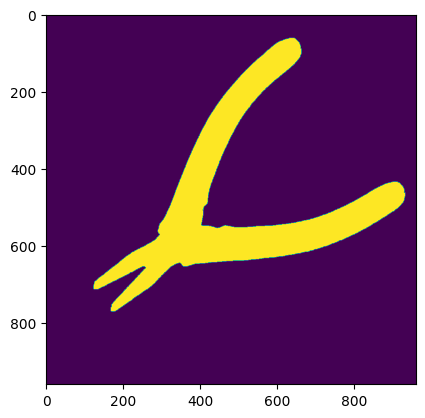

In [1]:
from expand_labelled_data import shadow_super_impose
shadow_super_impose(obj_dir, bgr_dir, results_dir)